In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Load the dataset 

In [2]:
!git clone https://github.com/amir-saniyan/HodaDatasetReader.git

Cloning into 'HodaDatasetReader'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24
Unpacking objects: 100% (24/24), done.


In [3]:
from HodaDatasetReader.HodaDatasetReader import read_hoda_dataset
train_images, train_labels = read_hoda_dataset('./HodaDatasetReader/DigitDB/Train 60000.cdb',images_height=32, images_width=32, one_hot=True, reshape=False)
test_images, test_labels = read_hoda_dataset('./HodaDatasetReader/DigitDB/Test 20000.cdb' ,images_height=32, images_width=32, one_hot=True, reshape=False)


<ipython-input-4-5db87576d8f8>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  figure.add_subplot(3, 3, i)


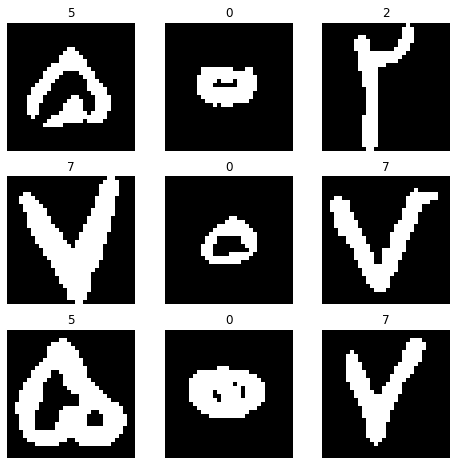

In [4]:
figure = plt.figure(figsize=(8, 8))
figure.add_subplot(3, 3, 1)
for i in range(1, 10):
    sample_img , sample_lbl = train_images[i], np.argmax(train_labels[i])
    figure.add_subplot(3, 3, i)
    plt.title(sample_lbl)
    plt.axis("off")
    plt.imshow(sample_img[:,:,0],  cmap="gray")
plt.show()

# Build the model

In [5]:
import tensorflow as tf


In [6]:
# Get help from https://github.com/sayakpaul/Spatial-Transformer-Networks-with-Keras/blob/main/STN.ipynb
# Get pixel value for coordinate vectors x and y from a  4D tensor image.
def get_pixel_value(img, x, y): 

    shape = tf.shape(x)
    batch_size = shape[0]
    height = shape[1]
    width = shape[2]

    idx = tf.range(0, batch_size)
    idx = tf.reshape(idx, (batch_size, 1, 1))
    b = tf.tile(idx, (1, height, width))

    indices = tf.stack([b, y, x], 3)

    return tf.gather_nd(img, indices)

# Returns a sampling grid, create an output feature map that is an affine transformation of the input feature map.
def affine_grid_generator(height, width, theta):

    batchnumber = tf.shape(theta)[0]

    # create normalized 2D grid
    x = tf.linspace(-1.0, 1.0, width)
    y = tf.linspace(-1.0, 1.0, height)
    x_t, y_t = tf.meshgrid(x, y)

    # flatten
    x_t_flat = tf.reshape(x_t, [-1])
    y_t_flat = tf.reshape(y_t, [-1])

    # homogeneous form
    ones = tf.ones_like(x_t_flat)
    sample_grid = tf.stack([x_t_flat, y_t_flat, ones])

    # repeat grid for batch number times
    sample_grid = tf.expand_dims(sample_grid, axis=0)
    sample_grid = tf.tile(sample_grid, tf.stack([batchnumber, 1, 1]))

    theta = tf.cast(theta, 'float32')
    sample_grid = tf.cast(sample_grid, 'float32')

    # batch multiply
    batch_grids = tf.matmul(theta, sample_grid)
    batch_grids = tf.reshape(batch_grids, [batchnumber, 2, height, width])

    return batch_grids

# Performs bilinear sampling of the input images according to the normalized coordinates provided by the sampling grid.
def bilinear_sampler(img, x, y):

    H = tf.shape(img)[1]
    W = tf.shape(img)[2]
    ymax = tf.cast(H - 1, 'int32')
    xmax = tf.cast(W - 1, 'int32')
    zero = tf.zeros([], dtype='int32')

    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')
    x = 0.5 * ((x + 1.0) * tf.cast(xmax-1, 'float32'))
    y = 0.5 * ((y + 1.0) * tf.cast(ymax-1, 'float32'))

    # grab 4 nearest corner points for each x,y
    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    x0 = tf.clip_by_value(x0, zero, xmax)
    x1 = tf.clip_by_value(x1, zero, xmax)
    y0 = tf.clip_by_value(y0, zero, ymax)
    y1 = tf.clip_by_value(y1, zero, ymax)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    x0 = tf.cast(x0, 'float32')
    x1 = tf.cast(x1, 'float32')
    y0 = tf.cast(y0, 'float32')
    y1 = tf.cast(y1, 'float32')

    # calculate deltas
    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    # add dimension for addition
    wa = tf.expand_dims(wa, axis=3)
    wb = tf.expand_dims(wb, axis=3)
    wc = tf.expand_dims(wc, axis=3)
    wd = tf.expand_dims(wd, axis=3)

    # compute output
    out = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])

    return out

In [19]:
class MyModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    # network layers here
    self.local = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, kernel_size=7, input_shape=(32, 32, 1), 
                      activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.MaxPool2D(strides=2),
        tf.keras.layers.Conv2D(10, kernel_size=5, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.MaxPool2D(strides=2),
    ])

    self.fc = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(3 * 2, kernel_initializer="zeros", bias_initializer=tf.keras.initializers.Constant([1, 0, 0, 0, 1, 0]))
    ])
    #Flat and drop out
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(256, activation="relu")
    self.dense2 = tf.keras.layers.Dense(128, activation="relu")
    self.dropout = tf.keras.layers.Dropout(0.5)
    self.outputlayer = tf.keras.layers.Dense(10, activation="softmax")

  # Spatial transformer network forward function
  def spatialtransformer(self, x):
        
    xs = self.local(x)
    xs = tf.reshape(xs, (-1, 10 * 4 * 4 ))
    theta = self.fc(xs)
    theta = tf.reshape(theta, (-1, 2, 3))
    
    grid = affine_grid_generator(32, 32, theta)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    x = bilinear_sampler(x, x_s, y_s)

    return x

  def call(self, inputs, training=False, usestn=True):
    theta = np.array([[1., 0, 0], [0, 1., 0]])
    if usestn:
      x = self.spatialtransformer(inputs)
    else:
      x = inputs
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dropout(x)
    output = self.outputlayer(x)
    return output




In [20]:
model = MyModel()
model.build(input_shape=(None, 32,32,1))
model.summary()

Model: "my_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 4, 4, 10)          2410      
                                                                 
 sequential_3 (Sequential)   (None, 6)                 5350      
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 dense_10 (Dense)            multiple                  262400    
                                                                 
 dense_11 (Dense)            multiple                  32896     
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dense_12 (Dense)            multiple                  1

# Now compile and fit the model 

In [13]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
model.fit(x=train_images, y=train_labels, validation_split=0.1, batch_size=64, epochs=5, shuffle=True)

Epoch 1/5
844/844 [==============================] - 7s 8ms/step - loss: 0.1835 - accuracy: 0.9464 - val_loss: 0.0713 - val_accuracy: 0.9778
Epoch 2/5
844/844 [==============================] - 7s 8ms/step - loss: 0.0678 - accuracy: 0.9805 - val_loss: 0.0529 - val_accuracy: 0.9835
Epoch 3/5
844/844 [==============================] - 9s 11ms/step - loss: 0.0414 - accuracy: 0.9876 - val_loss: 0.0518 - val_accuracy: 0.9850
Epoch 4/5
844/844 [==============================] - 7s 9ms/step - loss: 0.0318 - accuracy: 0.9899 - val_loss: 0.0423 - val_accuracy: 0.9897
Epoch 5/5
844/844 [==============================] - 6s 7ms/step - loss: 0.0246 - accuracy: 0.9922 - val_loss: 0.0528 - val_accuracy: 0.9882


# Now, lets test the model

test your model with the test data

**Note: Test without stn**

1/1 [==============================] - 0s 97ms/step
prediction :  [0]


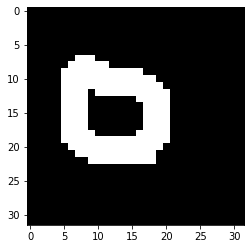

In [15]:
image = cv2.imread("/0.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap="gray")
imgarr = tf.expand_dims(image, 0)
predictions = model.predict(imgarr)
print("prediction : ",np.where(predictions[0] == 1.)[0])

1/1 [==============================] - 0s 57ms/step
prediction :  [5]


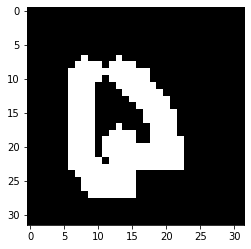

In [18]:
image = cv2.imread("/5.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap="gray")
imgarr = tf.expand_dims(image, 0)
predictions = model.predict(imgarr)
print("prediction : ",np.where(predictions[0] == 1.)[0])